# Signal Modulation classification 2
Train relatively simple model for signal modulation classification with the intention to deploy it on the CFU-Playground

**Note**
difference between this file and train_model.ipynb is that this one uses new (at the moment of writing) automation scripts to deploy model  

[Reference](https://www.mathworks.com/help/deeplearning/ug/modulation-classification-with-deep-learning.html)

## Imports

In [1]:
# imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from pathlib import Path

sys.path.append("..") # not good
from tools.data import load_data_simc_v1

2023-03-05 23:46:50.531986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 23:46:50.719934: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-05 23:46:51.530193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-03-05 23:46:51.530263: W 

In [2]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    imported_module = importlib.import_module(m)
    importlib.reload(imported_module)


## Data loading for model training/evaluation/training

Please refer to ../generate_data.py to generate data

All confiuguration should be in the cell below

In [3]:
modulations = [
    "16QAM",
    "64QAM",
    "8PSK",
    "B-FM",
    "BPSK",
    "CPFSK",
    "DSB-AM",
    "GFSK",
    "PAM4",
    "QPSK",
    "SSB-AM",
]

N_CLASSES = len(modulations)
MODEL_DATA_TYPE = np.float32
N_SAMPLES = 1024


SEED = 123456
set_seed(SEED)

# Training
train_model = False
N_EPOCHS = 12
BATCH_SIZE = 32
TRAIN_DATA_DIR = "/development/download/train_data_SIMC1_SNR_30_10k"

# Deployment
model_name = "simc_2"
MODELS_DIR = f'models_{model_name}_SNR_30_v1/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'



### Data preprocessing
The only thing I gonna to is to divide two parts of complex numbers into separate float number

### Data loading
Data is created in matlab using different impairments techniques, and rician fading simulation

In [5]:
reload_module("tools.data")
from tools.data import load_data_simc_v1
labels, data = load_data_simc_v1(
    classes=modulations, 
    path=Path(TRAIN_DATA_DIR), 
    model_dtype=MODEL_DATA_TYPE
)

100%|██████████| 11/11 [00:52<00:00,  4.73s/it]

[debug] Loaded train data with size 112640000 in 52.08878016471863s


There are 10_000 samples of size 1024x2 (complex numbers) for each of 11 modulations

In [6]:
print(len(labels))
print(data.shape)
print(data[0].shape)
print(data[0][:10])

110000
(110000, 1, 1024, 2)
(1, 1024, 2)
[[[1.2036071  0.23894253]
  [0.94644743 0.52149737]
  [0.84878576 0.7446801 ]
  ...
  [0.27026334 0.9789456 ]
  [0.22262351 1.1126622 ]
  [0.18643768 0.8866203 ]]]


In [7]:
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)
n_validation = int(0.1 * DS_SIZE)
n_test = DS_SIZE - n_train - n_validation

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)


In [8]:
train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [9]:
# Should save some memory
del data
del labels

## Model creation


In [10]:
# https://github.com/dksakkos/BatchNorm
class CustomBatchNorm(layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomBatchNorm, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="custom_batch_beta",
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="custom_batch_gamma",
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="custom_batch_moving_mean",
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False,
        )

        self.moving_variance = self.add_weight(
            name="custom_batch_moving_variance",
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False,
        )

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            assert len(inputs.shape) in (2, 4)
            if len(inputs.shape) > 2:
                axes = [0, 1, 2]
            else:
                axes = [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta


def create_model_v1():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


def create_model_original():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    BN1 = layers.BatchNormalization(epsilon=0.000010, name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)
    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)

    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = layers.BatchNormalization(epsilon=0.000010, name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)
    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)

    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = layers.BatchNormalization(epsilon=0.000010, name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)
    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)

    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = layers.BatchNormalization(epsilon=0.000010, name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)
    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)

    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = layers.BatchNormalization(epsilon=0.000010, name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)
    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)

    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = layers.BatchNormalization(epsilon=0.000010, name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)
    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


In [11]:
model = create_model_v1()
model.summary()

2023-03-05 23:49:27.422149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 23:49:27.439154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 23:49:27.439350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 23:49:27.440178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1024, 2)]      0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 1024, 16)       272       
                                                                 
 BN1_ (CustomBatchNorm)      (None, 1, 1024, 16)       64        
                                                                 
 re_lu (ReLU)                (None, 1, 1024, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 512, 16)       0         
 )                                                               
                                                                 
 CNN2_ (Conv2D)              (None, 1, 512, 24)        3096      
                                                             

In [12]:
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ 
# learning rate schedule
def step_decay(epoch):
    lrate = 0.02
    factor = epoch // 9
    lrate /= (10**factor)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)



In [13]:
if train_model:
    h = model.fit(
        train_data,
        train_labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(validation_data, validation_labels), 
        callbacks=[lrate]
    )
else:
    model = tf.keras.models.load_model(MODEL_TF)


In [13]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



NameError: name 'h' is not defined

In [14]:
test_preds = model.predict(test_data)

2023-03-05 23:49:45.396713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


 69/344 [=====>........................] - ETA: 0s

2023-03-05 23:49:46.957058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


344/344 [==============================] - 3s 2ms/step


In [15]:
pred_labels = np.argmax(test_preds, axis=1)
print(pred_labels[0:10])
print(test_labels[0:10])

[9 8 3 9 0 0 2 7 7 4]
[9 8 3 9 0 0 2 7 7 4]


Overall test accuracy: 0.9292727272727273
16QAM test accuracy: 0.8425742574257425
64QAM test accuracy: 0.7367387033398821
8PSK test accuracy: 0.9107142857142857
B-FM test accuracy: 0.9979859013091642
BPSK test accuracy: 0.9968152866242038
CPFSK test accuracy: 0.9989350372736954
DSB-AM test accuracy: 0.9635108481262328
GFSK test accuracy: 1.0
PAM4 test accuracy: 0.9950396825396826
QPSK test accuracy: 0.8753709198813057
SSB-AM test accuracy: 0.9177693761814745


<Axes: >

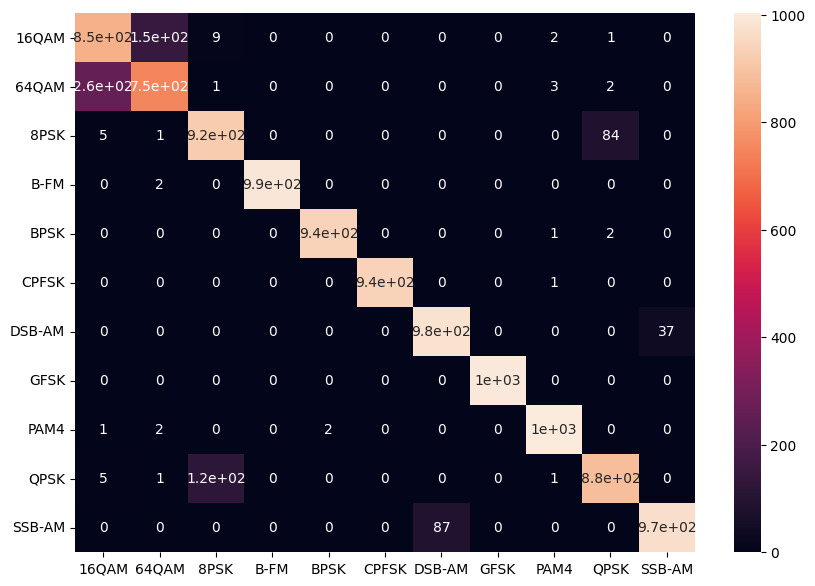

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

### Mode deployment

In [16]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models_simc_2_SNR_30_v1/model/assets


INFO:tensorflow:Assets written to: models_simc_2_SNR_30_v1/model/assets


In [17]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite
model_no_quant_tflite = to_tf_lite(MODEL_TF)
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

2023-03-05 23:49:58.435503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-05 23:49:58.435530: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-05 23:49:58.436255: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models_simc_2_SNR_30_v1/model
2023-03-05 23:49:58.438971: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-05 23:49:58.438987: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: models_simc_2_SNR_30_v1/model
2023-03-05 23:49:58.445146: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-05 23:49:58.447214: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-05 23:49:58.496213: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path

394972

In [18]:
# reload_module("tools.deployment_tools")
# from tools.deployment_tools import deploy_model_tflite

# deploy_model_tflite(
#     model_no_quant_tflite,
#     # test_data.reshape((-1, 1, 1, 1024, 2)),
#     test_data,
#     test_labels, 
#     model_name=model_name,
#     classes=modulations,
#     create_cfu_playground_proj=True,
# )

## Quantization
Let's quantize model, and check accuracy

In [19]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite

representative_ds = train_data[:2000]
print(representative_ds.dtype)
print(representative_ds.shape)
model_tflite = to_tf_lite(MODEL_TF, representative_ds=representative_ds, apply_quantization=True)
open(MODEL_TFLITE, "wb").write(model_tflite)

float32
(2000, 1, 1024, 2)


2023-03-05 23:49:59.208535: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-05 23:49:59.208558: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-05 23:49:59.208660: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models_simc_2_SNR_30_v1/model
2023-03-05 23:49:59.211303: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-05 23:49:59.211319: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: models_simc_2_SNR_30_v1/model
2023-03-05 23:49:59.218572: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-05 23:49:59.264949: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: models_simc_2_SNR_30_v1/model
2023-03-05 23:49:59.281480: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { ser

113008

In [20]:
from tools.deployment_tools import predict_tflite

test_preds_quant = np.squeeze(predict_tflite(model_tflite, test_data))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [21]:
pred_labels_quant = np.argmax(test_preds_quant, axis=1)
print(pred_labels_quant[:10])
print(test_labels[:10])

[9 8 3 9 0 0 2 7 7 4]
[9 8 3 9 0 0 2 7 7 4]


In [22]:
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels_quant)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels_quant[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")

cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels_quant)
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

NameError: name 'accuracy_score' is not defined

In [23]:
print(test_preds_quant.dtype)
print(test_preds_quant[0])

float32
[0.         0.         0.15234375 0.         0.         0.
 0.         0.         0.         0.84765625 0.        ]


In [28]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import deploy_model_tflite

deploy_model_tflite(
    # model_no_quant_tflite,
    model_tflite,
    test_data,
    test_labels, 
    model_name=model_name,
    classes=modulations,
    create_cfu_playground_proj=True,
    epsilon=10,
    apply_quantization=True,
)

[debug] Export test data


11it [00:00, 618.38it/s]

[Warning] proj directory already exists: /development/RISC-V-SIMD-extension-for-the-AI-workload/proj/simc_2
